In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import random
import numpy as np
import os
import matplotlib.pyplot as plt

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


# Memory with recurrent PCN

This is a demo for recurrent predictive coding nets (aka covariance-learning pcns) in associative memory task. The implementation of recurrent pcns is based on a new subclass of `PCLayer` called `RecPCLayer`.

Recurrent pcns work in a similar way to Hopfield Networks (and we can actually show a close relationship between their energy functions!)

In [2]:
def get_mnist(options):
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Lambda(lambda x: torch.flatten(x))])
    train = datasets.MNIST('./data', train=True, transform=transform, download=True)
    test = datasets.MNIST('./data', train=False, transform=transform, download=True)
    
    if options.train_size != len(train):
        train = torch.utils.data.Subset(train, random.sample(range(len(train)), options.train_size))
    if options.test_size != len(test):
        test = torch.utils.data.Subset(test, random.sample(range(len(test)), options.test_size))

    # Split the training set into training and validation sets
    train_len = int(len(train) * 0.9)  # 80% of data for training
    val_len = len(train) - train_len   # remaining 20% for validation
    train_set, val_set = torch.utils.data.random_split(train, [train_len, val_len])
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=options.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=options.batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=options.batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
def mask_input(input):
    """mask a given input on bottom half of image and return mask and corrupted input
    """
    h, w = input.shape[1], input.shape[2]
    device = input.device
    # take top half of image
    mask_top = torch.ones_like(input[:, :input.shape[1]//2, :]).to(device)
    input_top = mask_top * input[:, :input.shape[1]//2, :].clone().detach().requires_grad_(False)
    # mask bottom half of image
    mask_bottom = torch.zeros_like(input[:, input.shape[1]//2:, :]).to(device)
    input_bottom = mask_bottom * input[:, input.shape[1]//2:, :].clone().detach().requires_grad_(False)
    # concatenate masks
    mask = torch.cat((mask_top, mask_bottom), dim=1)
    corrupted_input = torch.cat((input_top, input_bottom), dim=1)
    return mask, corrupted_input

def blur_input(input):
    h, w = input.shape[1], input.shape[2]
    device = input.device
    # add small gaussian noise to input
    mask = (0.1 * torch.randn(input.shape)).to(device)
    return mask, mask + input
    

In [4]:
class Options:
    pass
options = Options()

options.learning_rate = 1e-3
options.epochs = 200
options.train_size = 5
options.batch_size = 5
options.test_size = 5

In [5]:
# a single layer recurrent pcn
# note that we don't need a pc layer for training
model = pc.RecPCLayer(784, 
    is_zero_diagonal_Wr=True,
).to(device)

# gaussian data
# X = create_gaussian(options.sample_size, seed=1).to(device)
train_loader, val_loader, test_loader = get_mnist(options)
X, _ = next(iter(train_loader)) # get a batch of data
X = X.to(device)
print(X.shape)
model.train()
pc_trainer = pc.PCTrainer(
    model, 
    update_p_at='last',
    optimizer_p_fn=optim.Adam,
    optimizer_p_kwargs={"lr": options.learning_rate},
    plot_progress_at=[],
)

losses = []
for i in range(options.epochs):
    # for single-layer rPCN we don't need a loss function
    # the model is trained on the internal energy of this PCLayer
    results = pc_trainer.train_on_batch(
        inputs=X,
        loss_fn=None, 
        is_log_progress=False,
        is_return_results_every_t=False,
    )
    loss = results['energy'][0]
    if i % 10 == 0:
        print(f'epoch {i} loss: {loss}')
    losses.append(results['energy'][0])

torch.Size([4, 784])
epoch 0 loss: 214.01773071289062
epoch 10 loss: 18.334232330322266
epoch 20 loss: 7.556211948394775
epoch 30 loss: 2.76900053024292
epoch 40 loss: 1.1175117492675781
epoch 50 loss: 0.37081438302993774
epoch 60 loss: 0.12785157561302185
epoch 70 loss: 0.05215900391340256
epoch 80 loss: 0.018046701326966286
epoch 90 loss: 0.006561806425452232
epoch 100 loss: 0.0022131316363811493
epoch 110 loss: 0.000907537410967052
epoch 120 loss: 0.00031103016226552427
epoch 130 loss: 9.71607951214537e-05
epoch 140 loss: 3.405761162866838e-05
epoch 150 loss: 1.3446982848108746e-05
epoch 160 loss: 4.980541689292295e-06
epoch 170 loss: 1.671848508522089e-06
epoch 180 loss: 5.958319206911256e-07
epoch 190 loss: 2.2302506863525196e-07


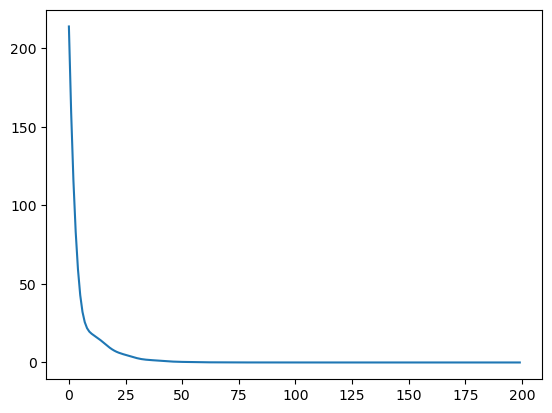

In [6]:
plt.figure()
plt.plot(losses)
plt.show()

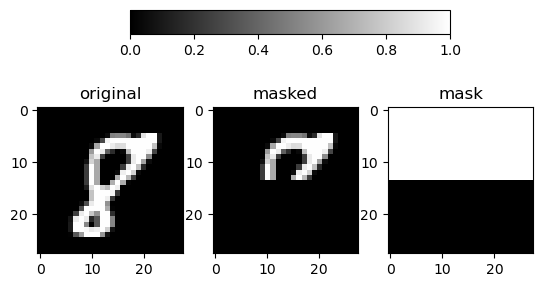

In [7]:
# test data: masked input
X_test = X[:4].reshape(-1, 28, 28)
mask, X_c = mask_input(X_test)
X_c2 = X_c.clone()

# show exmaples of original and masked data
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_test[0].cpu().numpy(), cmap='gray')
ax[0].set_title('original')
ax[1].imshow(X_c[0].cpu().detach().numpy(), cmap='gray')
ax[1].set_title('masked')
im = ax[2].imshow(mask[0].cpu().numpy(), cmap='gray')
ax[2].set_title('mask')
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
plt.show()

In [10]:
# test model; set eval to initialize value nodes by sampling
# note that model.eval doesn't prohibit training, it only affects dropout and batchnorm
# also note that the default sample fn of a (rec)pclayer is to set it to the input to the layer, which is the corrupted input here
# this is what we (should) use here
model.set_mode('inference')

pc_tester = pc.PCTrainer(
    model, 
    T=1000,
    update_x_at='all',
    optimizer_x_fn=optim.SGD,
    optimizer_x_kwargs={"lr": 0.01},
    update_p_at='never', # do not update parameters during inference
    plot_progress_at=[],
)

results = pc_tester.train_on_batch(
    inputs=X_c.reshape(-1, 784),
    is_log_progress=True,
    is_return_results_every_t=True,
)

| e: 6.341e-03 | o: 6.341e-03 |: 100%|██████████| 1000/1000 [00:02<00:00, 463.60it/s]


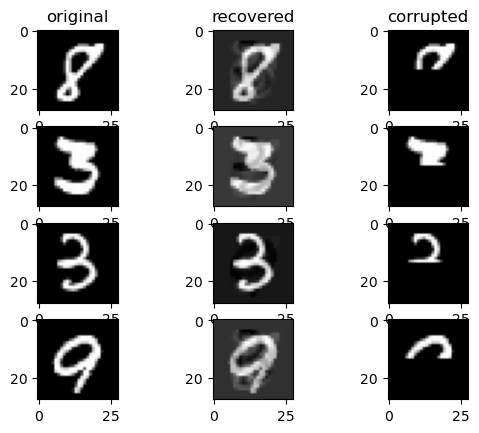

In [11]:
pred = model.get_x().reshape(-1, 28, 28)

# show exmaples of original and predicted data
fig, ax = plt.subplots(pred.shape[0], 3)
for i in range(pred.shape[0]):
    ax[i, 0].imshow(X_test[i].cpu().numpy(), cmap='gray')
    ax[i, 1].imshow(pred[i].detach().cpu().numpy(), cmap='gray')
    ax[i, 2].imshow(X_c2[i].detach().cpu().numpy(), cmap='gray')
ax[0, 0].set_title('original')
ax[0, 1].set_title('recovered')
ax[0, 2].set_title('corrupted')
plt.show()
